# O2S model



In [1]:
%load_ext lab_black

import tensorflow as tf
import numpy as np
import pandas as pd

### Parameters block for Papermill
- Instead of using model_cfg directly, this extra step is needed for batch run using Papermill

In [2]:
code_name = 'O2S_bert_H500_L1_S10M'

embedding = 'bert'
sample_name = 'hal'  #hal log frequency with clipping like HS04 (did not use it for control...)
sample_rng_seed = 1234
tf_rng_seed = 4321

# Model architechture
o_input_dim = 119
hidden_units = 500
cleanup_units = 50  # useless
rnn_activation = 'sigmoid'
regularizer_const = 0.

p_noise = 0.  # i.e. w_pp, w_pc, and w_cp noise
tau = 1.
max_unit_time = 2.

# Training
n_mil_sample = 10.
batch_size = 128
learning_rate = 0.005
save_freq = 5

In [3]:
x_name = 'x_train_{}.npz'.format(embedding)
y_name = 'y_train_{}.npz'.format(embedding)
csv_name = 'df_train_{}.csv'.format(embedding)

if embedding == 'tasa':
    sem_units = 300
if embedding == 'bert':
    sem_units = 1024

### Packing parameters into model_cfg

In [4]:
from meta import model_cfg

cfg = model_cfg(
    code_name=code_name,
    x_name=x_name,
    y_name=y_name,
    csv_name=csv_name,
    sample_name=sample_name,
    sample_rng_seed=sample_rng_seed,
    tf_rng_seed=tf_rng_seed,
    use_semantic=False,
    sem_param_gf=0,
    sem_param_gi=0,
    sem_param_kf=0,
    sem_param_ki=0,
    sem_param_hf=0,
    sem_param_hi=0,
    o_input_dim=o_input_dim,
    hidden_units=hidden_units,
    pho_units=sem_units,  # Output become semantic embedding vector
    cleanup_units=None,
    embed_attractor_cfg=None,
    embed_attractor_h5=None,
    w_oh_noise=0.,
    w_hp_noise=0.,
    w_pp_noise=p_noise,
    w_pc_noise=p_noise,
    w_cp_noise=p_noise,
    tau=tau,
    max_unit_time=max_unit_time,
    n_mil_sample=n_mil_sample,
    batch_size=batch_size,
    rnn_activation=rnn_activation,
    regularizer_const=regularizer_const,
    learning_rate=learning_rate,
    save_freq=save_freq,
    bq_dataset=None
)

# TF random seed (Sampling is out of TF scope... change sample_rng_seed instead)
tf.random.set_seed(cfg.tf_rng_seed)

# Preload data
from data_wrangling import sample_generator, my_data
data = my_data(cfg)

==========Orthographic representation==========
x_train shape: (3262, 119)
y_train shape: (3262, 1024)


# Modeling

## Building

In [5]:
def build_model(training=True):
    # Organization principal:
    # Structure things, such as repeat vector should build within the model
    # Static calculation of input --> Easier to modify --> build within sample generator

    from tensorflow.keras import Model
    from tensorflow.keras.layers import Layer, Input, concatenate, multiply, RepeatVector, Dense
    from tensorflow.keras.optimizers import Adam
    from modeling import rnn
    #     from modeling_without_cleanup import rnn_no_cleanup_no_pp

    # Train/test mode checking
    cfg.noise_on() if training is True else cfg.noise_off()

    input_o = Input(shape=(cfg.o_input_dim, ), name="Orthography")
    hidden1 = Dense(
        cfg.hidden_units, name="Hidden1", activation=cfg.rnn_activation
    )(input_o)
    #     hidden2 = Dense(cfg.hidden_units, name="Hidden2",
    #                     activation='sigmoid')(hidden1)
    #     hidden3 = Dense(cfg.hidden_units, name="Hidden3",
    #                     activation='sigmoid')(hidden2)
    output = Dense(cfg.pho_units, name="Semantics")(
        hidden1
    )  # Should rename pho_unit to output unit later... a bit confusing
    model = Model(input_o, output)

    model.compile(
        loss='mse',
        optimizer=Adam(
            learning_rate=cfg.learning_rate,
            beta_1=0.9,
            beta_2=0.999,
            amsgrad=False
        ),
        metrics=['accuracy', 'mse']
    )

    model.summary()
    return model


model = build_model(training=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Orthography (InputLayer)     [(None, 119)]             0         
_________________________________________________________________
Hidden1 (Dense)              (None, 500)               60000     
_________________________________________________________________
Semantics (Dense)            (None, 1024)              513024    
Total params: 573,024
Trainable params: 573,024
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
import h5py, pickle, os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from data_wrangling import sample_generator
from IPython.display import clear_output

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=20)

checkpoint = ModelCheckpoint(
    cfg.path_weights_checkpoint,
    verbose=1,
    save_freq=cfg.save_freq_sample,
    save_weights_only=True
)

history = model.fit(
    sample_generator(cfg, data),
    steps_per_epoch=cfg.steps_per_epoch,
    epochs=cfg.nEpo,
    verbose=2,
    callbacks=[checkpoint],
    #     callbacks=[checkpoint, es],
)

# Saving history and model
pickle_out = open(cfg.path_history_pickle, "wb")
pickle.dump(history.history, pickle_out)
pickle_out.close()

clear_output()
print('Training done')


# Reporting

### Training history

In [6]:
from evaluate import training_history

hist = training_history(cfg.path_history_pickle)
hist.plot_mse()

alt.Chart(...)

### Parse item level stats

In [7]:
from evaluate import eval_O2S
model = build_model(training=False)
model.load_weights(cfg.path_weight_folder + 'ep1000.h5')
eval_embeddings = eval_O2S(model, data)
eval_embeddings.df.to_csv(cfg.path_model_folder + 'results.csv')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Orthography (InputLayer)     [(None, 119)]             0         
_________________________________________________________________
Hidden1 (Dense)              (None, 500)               60000     
_________________________________________________________________
Semantics (Dense)            (None, 1024)              513024    
Total params: 573,024
Trainable params: 573,024
Non-trainable params: 0
_________________________________________________________________


In [8]:
eval_embeddings.plot_heatmap(save_file=cfg.path_plot_folder + 'heatmap.html')

alt.Chart(...)

In [9]:
eval_embeddings.plot_scatter(
    'model_mse', 'lwf', save_file=cfg.path_plot_folder + 'scatter_lwf.html'
)

alt.VConcatChart(...)

### Model weights and biases

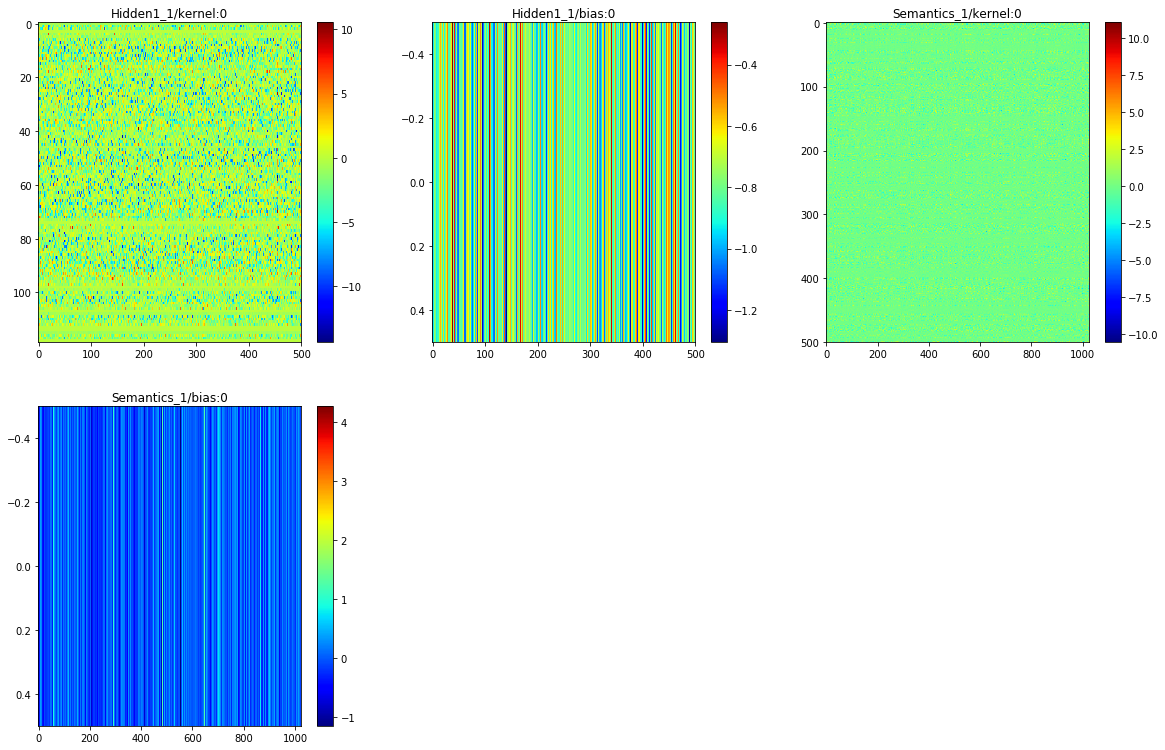

In [10]:
from evaluate import plot_variables
plot_variables(model)

In [11]:
!jupyter nbconvert --output-dir=$cfg.path_model_folder --to html basicO2S_master.ipynb

[NbConvertApp] Converting notebook basicO2S_master.ipynb to html
[NbConvertApp] Writing 1935258 bytes to models/O2S_bert_H500_L1_S10M/basicO2S_master.html
